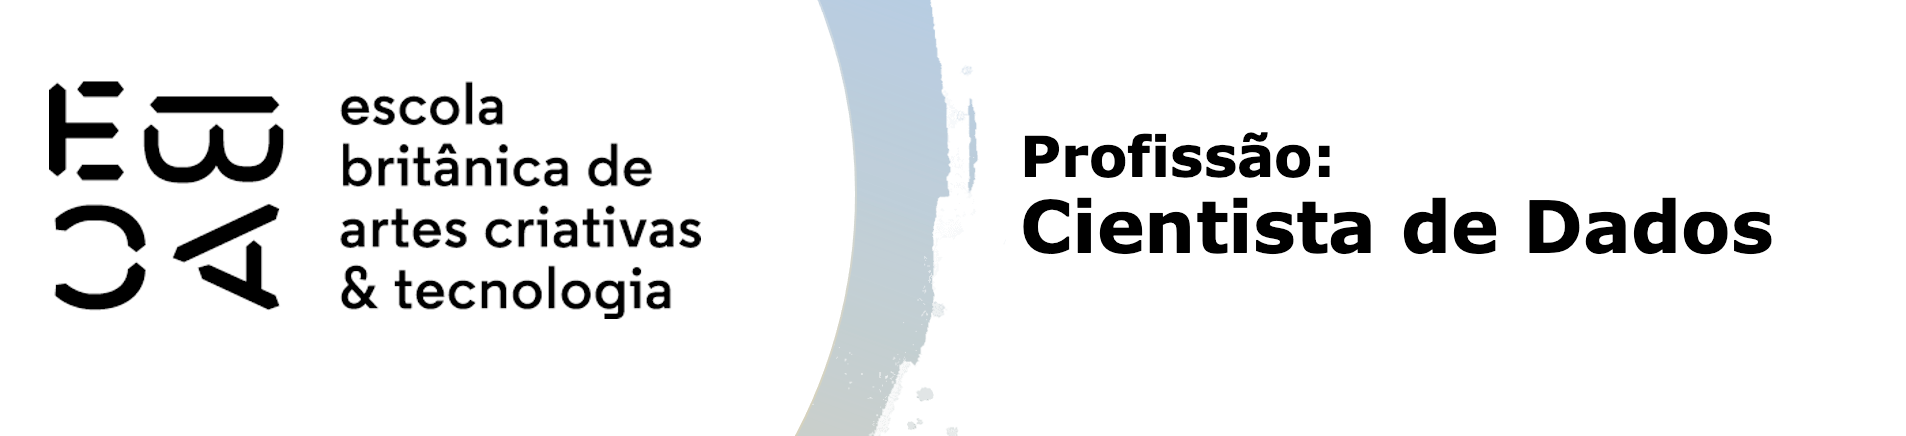

# Tarefa

Carregue a base ```NFP.ftr```. Essa base é proveniente do projeto #AMABiliDados, e contém dados da nota fiscal paulista cadastrados para doação automática para a AMA, Associação de Amigos do Autista. 

A *Nota Fiscal Paulista* é um programa de incentivo do governo do estado de São Paulo, que retorna um pedacinho do ICMS ao consumidor sempre que solicita o registro do seu CPF na nota. Nesse programa, o contribuinte pode direcionar seus créditos a uma ONG, e quando faz isso, sempre que faz esse consumidor cadastrado faz uma compra, os créditos de notas emitidas pelo mesmo estabelecimento não identificadas (notas sem CPF) são "arrastados" para a ONG na forma de uma doação.

Clique no link, caso queira saber mais sobre a [AMA](https://www.ama.org.br/site/).<br>
Clique no link, caso queira saber como o cidadão pode ser um [doador da NFP](https://doacao1.ama.org.br/sitenfp).

Essa base possui dados das notas cujos contribuintes direcionaram seus créditos à AMA. Seus campos estão descritos abaixo:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#ignore warnings
import warnings
warnings.filterwarnings('ignore')



## Análise da probabilidade de retorno

Considere somente os dados de janeiro de 2020 em diante para esta análise.

- Analise a proporção de notas que tiveram retorno>0 por categoria de estabelecimento. Esta análise pode ser por tabela ou gráfico.

In [123]:
df = pd.read_pickle('base_nfp.pkl')
df.head()
df_filtrado = df[df['Data Emissão'].dt.year >= 2020].dropna()
df_filtrado.head(2)

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
64598,05.234.750/0001-41,TX BURGER LTDA,77882,2020-01-01,78.80,2020-08-01,0.0,A Calcular,2019,2,0.0,0,não definido
64599,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,2020-01-01,22.71,2020-01-01,0.0,A Calcular,2019,2,0.0,0,Mercado


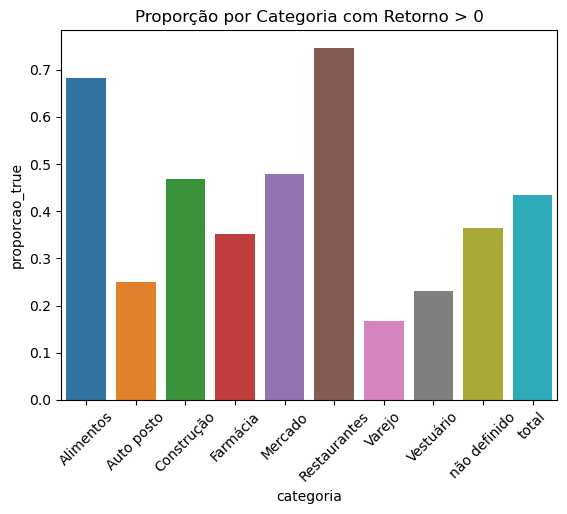

Retorno,False,True,total,proporcao_true
categoria,,,,
Alimentos,1608,3442,5050,0.681584
Auto posto,405,135,540,0.250000
Construção,8521,7523,16044,0.468898
Farmácia,6607,3582,10189,0.351556
Mercado,14376,13177,27553,0.478242
Restaurantes,553,1626,2179,0.746214
Varejo,3481,701,4182,0.167623
Vestuário,1472,443,1915,0.231332
não definido,11659,6689,18348,0.364563


In [124]:
categorias = pd.crosstab(df_filtrado['categoria'], df_filtrado['Retorno'] > 0, margins=True,margins_name='total')
categorias['proporcao_true'] = categorias[True] / categorias['total']

# Gráfico de barras para proporção
sns.barplot(data=categorias.reset_index(), x='categoria', y='proporcao_true')
plt.title('Proporção por Categoria com Retorno > 0')
plt.tick_params(axis='x', rotation=45)
plt.show()

categorias

## Cálculo do WOE

- Calcule o WOE das categorias, sendo que o evento em questão é a nota ter retorno>0.
- Analise este WOE por tabela e por gráfico.

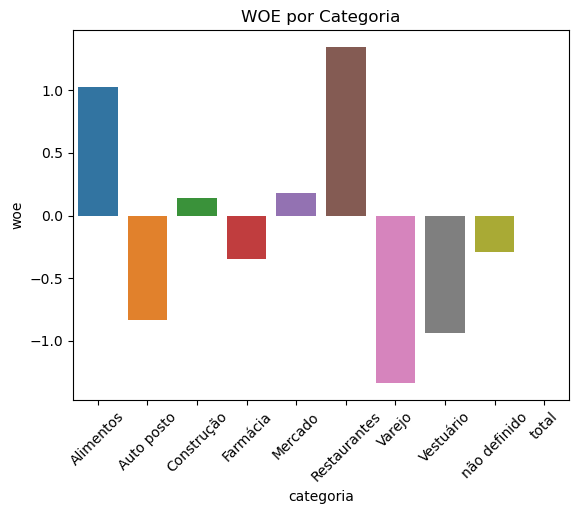

Retorno,False,True,total,proporcao_true,odds,odds_ratio,woe
categoria,,,,,,,
Alimentos,1608,3442,5050,0.681584,2.140547,2.792382,1.026895
Auto posto,405,135,540,0.250000,0.333333,0.434839,-0.832779
Construção,8521,7523,16044,0.468898,0.882878,1.151730,0.141265
Farmácia,6607,3582,10189,0.351556,0.542152,0.707247,-0.346375
Mercado,14376,13177,27553,0.478242,0.916597,1.195717,0.178746
Restaurantes,553,1626,2179,0.746214,2.940325,3.835707,1.344354
Varejo,3481,701,4182,0.167623,0.201379,0.262702,-1.336733
Vestuário,1472,443,1915,0.231332,0.300951,0.392596,-0.934974
não definido,11659,6689,18348,0.364563,0.573720,0.748428,-0.289780


In [125]:
categorias['odds'] = categorias[True]/categorias[False]
categorias['odds_ratio'] = categorias['odds']/categorias.loc['total', 'odds']
categorias['woe'] = np.log(categorias.odds_ratio)

# Gráfico de barras para WOE
sns.barplot(data=categorias.reset_index(), x='categoria', y='woe')
plt.title('WOE por Categoria')
plt.tick_params(axis='x', rotation=45)
plt.show()


categorias

## Cálculo do *Information Value*

Calcule o *IV* dessa variável.

In [126]:
categorias.columns[0]

False

In [127]:
categorias['pct_nao_evento'] = categorias[categorias.columns[0]]/categorias.loc['total',categorias.columns[0]]
categorias['pct_evento'] = categorias[categorias.columns[1]]/categorias.loc['total',categorias.columns[1]]
categorias['iv_parcial'] = (categorias.pct_evento - categorias.pct_nao_evento)*categorias.woe

print(categorias.iv_parcial.sum())
categorias


0.2409644851976443


Retorno,False,True,total,proporcao_true,odds,odds_ratio,woe,pct_nao_evento,pct_evento,iv_parcial
categoria,,,,,,,,,,
Alimentos,1608,3442,5050,0.681584,2.140547,2.792382,1.026895,0.033031,0.092234,0.060796
Auto posto,405,135,540,0.250000,0.333333,0.434839,-0.832779,0.008319,0.003618,0.003916
Construção,8521,7523,16044,0.468898,0.882878,1.151730,0.141265,0.175034,0.201592,0.003752
Farmácia,6607,3582,10189,0.351556,0.542152,0.707247,-0.346375,0.135718,0.095986,0.013762
Mercado,14376,13177,27553,0.478242,0.916597,1.195717,0.178746,0.295304,0.353100,0.010331
Restaurantes,553,1626,2179,0.746214,2.940325,3.835707,1.344354,0.011359,0.043571,0.043304
Varejo,3481,701,4182,0.167623,0.201379,0.262702,-1.336733,0.071505,0.018785,0.070473
Vestuário,1472,443,1915,0.231332,0.300951,0.392596,-0.934974,0.030237,0.011871,0.017172
não definido,11659,6689,18348,0.364563,0.573720,0.748428,-0.289780,0.239493,0.179243,0.017459


## Conclua

Não se esqueça de registrar suas conclusões em uma célula de texto. <font color='red'>**Sugestão:**</font> tente alterar a cor da fonte nesta célula para diferenciá-la das demais.


<font color='red'>CNPJ de restaurantes, mercados e alimentos sãoq ue possuem melhor retorno > 0 mais frequentes, o cálculo do *Information Value* mostrou resultados muito altos e segundo a interpretação Naeem Siddiqi, esse valor é suspeito.</font>

Naeem Siddiqi recomenda as seguintes regras de bolso para interpretar o IV:

|Faixa|Poder preditivo|
|:-|:-|
|0 a 0,02| Inútil |
|0,02 a 0,1| Fraco |
|0,1 a 0,3| Médio |
|0,3 a 0,5| Forte |
|0,5 ou mais| Suspeito de tão alto |